<a href="https://colab.research.google.com/github/BojanKomazec/tensorflow-demo-notebooks/blob/main/autoencoder_denoise_mnist_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist

In [13]:
#
# Load data
#
# MNIST dataset. 28x28 pixel grayscale images. Pixel values are 0 to 255. 
# 0 means background (white), 255 means foreground (black).
#
 
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [14]:
# remove all size 1 dimensions
# data = tf.squeeze(data)
# labels = tf.squeeze(labels)

def display_samples(data, labels):
  NUMBER_OF_EXAMPLES = 9
  NUMBER_OF_ROWS = 3
  NUMBER_OF_COLUMNS = 3

  fig, axes = plt.subplots(
      NUMBER_OF_ROWS, NUMBER_OF_COLUMNS, 
      figsize=(1.5*NUMBER_OF_COLUMNS, 1.5*NUMBER_OF_ROWS)
  )

  for i in range(NUMBER_OF_EXAMPLES):
      ax = axes[i//NUMBER_OF_COLUMNS, i%NUMBER_OF_COLUMNS]
      ax.imshow(data[i], cmap=plt.cm.binary)
      ax.set_title(f'Label: {labels[i]}')

  plt.tight_layout()
  plt.show()

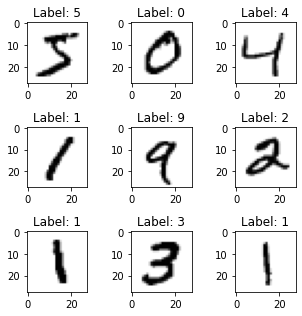

In [15]:
#
# (Optional)
# Display multiple images from the dataset in order to get a better overview
# of data
#
display_samples(x_train, y_train)

In [16]:
#
# Min-Max Normalization
#

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [17]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [18]:
#
# Adding random noise to the images
#

noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

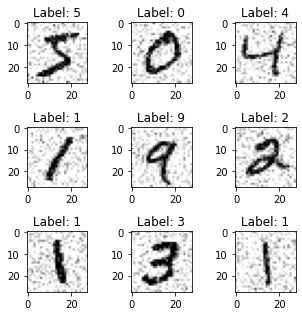

In [19]:
display_samples(tf.squeeze(x_train_noisy), tf.squeeze(y_train))

In [21]:
encoder = tf.keras.Sequential([
  keras.layers.Input(shape=(28, 28, 1)),
  keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
  keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

In [22]:
decoder = tf.keras.Sequential([
  keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
  keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
  keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

In [30]:
#
# Need to use functional API in order to model this NN
#
img = keras.layers.Input(shape = (28, 28, 1))
latent_vector = encoder(img)
output = decoder(latent_vector)
model = keras.models.Model(inputs = img, outputs = output)

In [31]:
model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())

In [32]:
model.fit(x_train_noisy, x_train,
  epochs=10,
  shuffle=True,
  validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0160 - val_loss: 0.0046
Epoch 2/10
1875/1875 [==============================] - 68s 36ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 3/10
1875/1875 [==============================] - 68s 36ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 4/10
1875/1875 [==============================] - 68s 36ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 5/10
1875/1875 [==============================] - 69s 37ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 6/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 7/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/10
1875/1875 [==============================] - 70s 37m

In [34]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [35]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [37]:
encoded_imgs = encoder(x_test).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

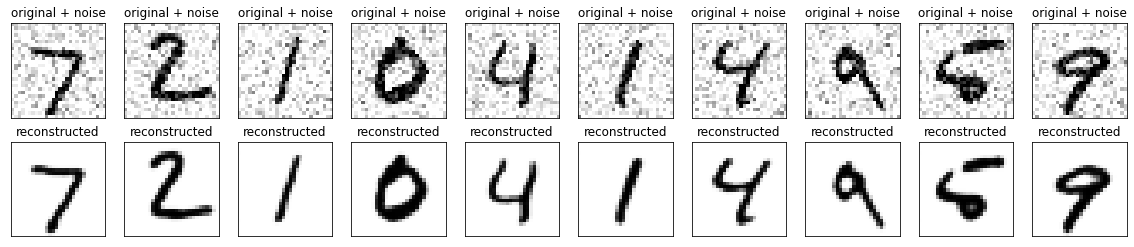

In [40]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]), cmap=plt.cm.binary)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]), cmap=plt.cm.binary)
    #plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()